# Load libraries

In [1]:
import pandas as pd
from IPython.display import display

# EDA

In [2]:
train_df = pd.read_csv("../dataset/train.tsv", sep="\t")
test_df = pd.read_csv("../dataset/train.tsv", sep="\t")

In [3]:
display("Train dataframe info")
display(train_df.info(verbose=True))

'Train dataframe info'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


None

In [4]:
display("Test dataframe info")
display(test_df.info(verbose=True))

'Test dataframe info'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


None

In [5]:
display(train_df['is_fake'].value_counts())
display(test_df['is_fake'].value_counts())

1    2879
0    2879
Name: is_fake, dtype: int64

1    2879
0    2879
Name: is_fake, dtype: int64

In [6]:
print(train_df['title'].isna().sum())
print(test_df['title'].isna().sum())

0
0


Text(0.5, 1.0, 'Amount of words in title')

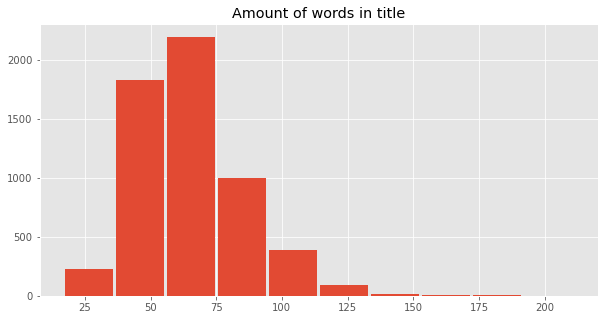

In [7]:
hist_params = dict(figsize=(10, 5), grid=True, rwidth=0.95)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
ax = train_df['title'].str.len().hist(**hist_params)
ax.set_title("Amount of words in title")

Text(0.5, 1.0, 'Word len in title')

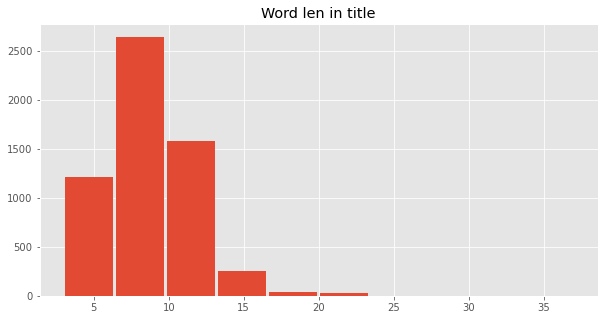

In [8]:
ax = train_df['title'].str.split().map(lambda x: len(x)).hist(**hist_params)
ax.set_title("Word len in title")

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

get_top_ngram(train_df['title'], 2)

[('из за', 155),
 ('мира по', 26),
 ('цен на', 23),
 ('сборной россии', 23),
 ('россии запретят', 21),
 ('россии по', 20),
 ('во время', 20),
 ('госдуме предложили', 20),
 ('тысяч рублей', 20),
 ('по футболу', 19)]

In [10]:
def create_word_corpus(df, target, target_colum = "is_fake", text_colum ='title'):
    corpus=[]
    for title in df[df[target_colum] == target][text_colum].str.split():
        for word in title:
            corpus.append(word)
    return corpus

In [11]:
from collections import Counter
from nltk.corpus import stopwords
import seaborn as sns
counter=Counter(create_word_corpus(train_df, 0))
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if word not in stopwords.words("russian"):
        x.append(word)
        y.append(count)

<AxesSubplot:>

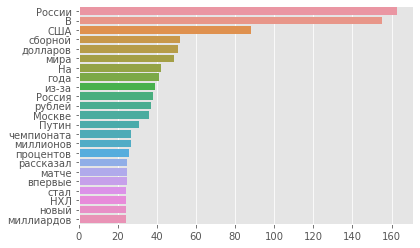

In [12]:
sns.barplot(x=y,y=x)

<AxesSubplot:>

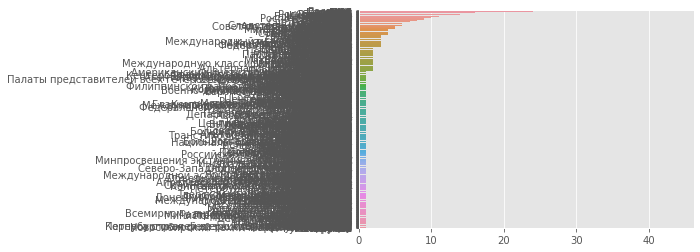

In [68]:
# Чекнуть url и в целом мусор
import spacy


def ner(text, ent="ORG"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]


nlp = spacy.load("ru_core_news_lg")

ent = train_df['title'].apply(lambda x: ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()
x, y = map(list, zip(*count))
sns.barplot(x=y, y=x)

'Plots for column title'

is_fake
0    [(из за, 40), (мира по, 21), (по футболу, 17),...
1    [(из за, 115), (россии запретят, 21), (госдуме...
dtype: object

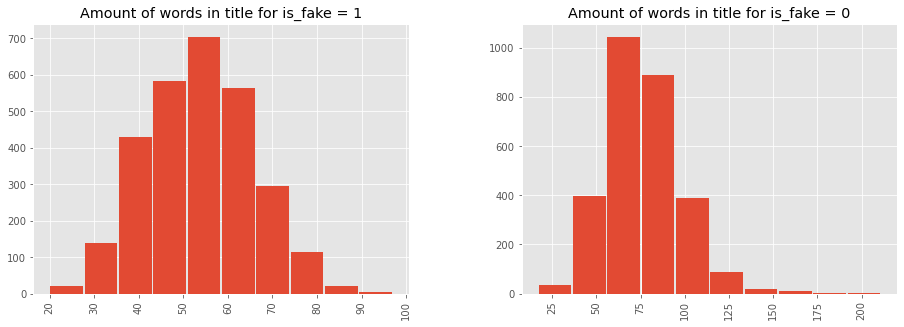

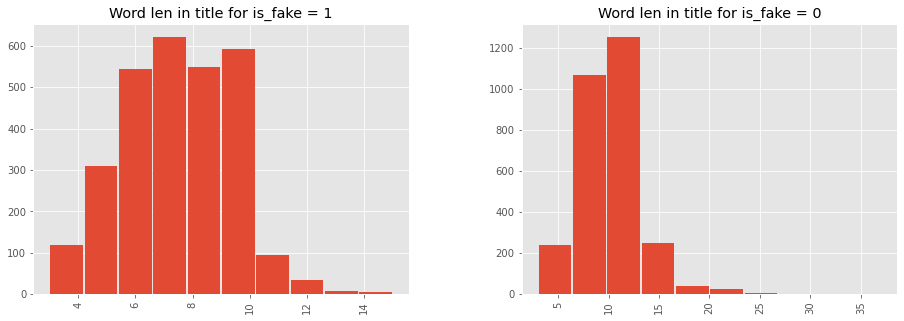

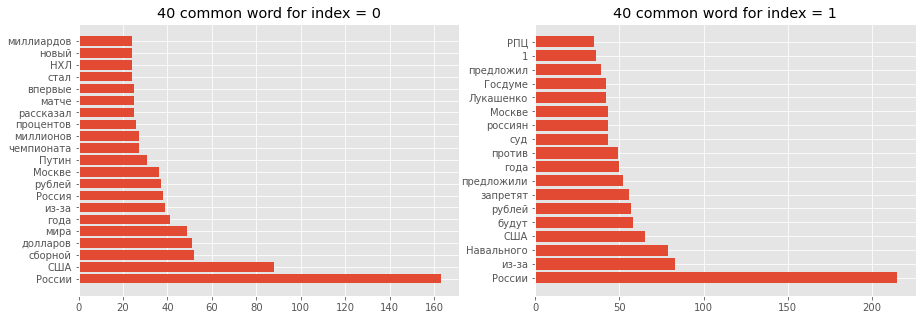

In [6]:
from typing import List
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
plt.style.use('ggplot')


def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]


def get_words(df: pd.DataFrame, ):
    corpus = []
    for title in df.str.split():
        for word in title:
            corpus.append(word)
    counter = Counter(corpus)
    most = counter.most_common()
    x = []
    y = []
    for word, count in most[:40]:
        if word.lower() not in stopwords.words("russian"):
            x.append(word)
            y.append(count)
    return x, y


def generic_nlp_eda(df: pd.DataFrame, text_columns: List[str], target_colum: str):
    targets = df[target_colum].unique()
    hist_params = dict(figsize=(15, 5), grid=True, rwidth=0.95)
    for text_column in text_columns:
        display(f"Plots for column {text_column}")
        grouped = df.groupby(target_colum)
        plot_sent_len(grouped, hist_params, target_colum, targets, text_column)
        plot_amount_of_words(grouped, hist_params, target_colum, targets, text_column)
        display(grouped.apply(lambda x: get_top_ngram(x[text_column], 2)))
        display(grouped.apply(lambda x: get_top_ngram(x[text_column], 2)))
        df_ = grouped.apply(lambda x : get_words(x[text_column]))
        fig, axes = plt.subplots(ncols=len(targets), figsize=hist_params['figsize'])
        for i, (index, (y, x)) in enumerate(df_.iteritems()):
            axes[i].barh(width=x, y=y)
            axes[i].set_title(f"40 common word for index = {index}")
        plt.show()


def plot_amount_of_words(grouped, hist_params, target_colum, targets, text_column):
    axes = grouped.apply(lambda df_p: df_p[text_column].str.split().map(lambda x: len(x))).hist(**hist_params,
                                                                                                by=target_colum)
    for i, ax in zip(targets, axes):
        ax.set_title(f"Word len in {text_column} for {target_colum} = {i}")


def plot_sent_len(grouped, hist_params, target_colum, targets, text_column):
    axes = grouped.apply(lambda df_p: df_p[text_column].str.len()).hist(**hist_params, by=target_colum)
    for i, ax in zip(targets, axes):
        ax.set_title(f"Amount of words in {text_column} for {target_colum} = {i}")


generic_nlp_eda(train_df, ['title'], 'is_fake')

In [ ]:
# задачки для EDA. Есть ли пунктуация, есть ли перекос по словам

In [13]:
import string

train_df['title'].str.findall('[{}]'.format(string.punctuation)).apply(lambda x: len(x) > 0).sum()
# train_df['title'][with_punkt]

1528

In [24]:
train_df['title'].str.findall('[{}]'.format(string.punctuation)).explode().dropna().unique()

array([':', ',', '-', '&', '*', '.', '%', '/', '?', '!', '+', '(', ')',
       '_', '#', ';', '$', '`'], dtype=object)

In [27]:
unique_set = set()
for i in train_df['title'].str.findall('[{}]'.format(string.punctuation)):
    for el in i:
        unique_set.add(el)
unique_set

{'!',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '?',
 '_',
 '`'}

18